```
Prebared by: Ro'a Nafi
```

In [ ]:
#connectto googleDrive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Data From Drive

In [ ]:
#connectto googleDrive
from google.colab import drive
drive.mount('/content/drive')


import os

train_path = "/content/drive/MyDrive/Spoken/Project/Dataset/Train"
test_path = "/content/drive/MyDrive/Spoken/Project/Dataset/Test"


def read_audio_files(data_path, categories):
    audio_files = {}
    print(f"Reading data from path: {data_path}")

    for category, subfolders in categories.items():
        audio_files[category] = []
       # print(f"Processing category: {category}, subfolders: {subfolders}")
        for subfolder in subfolders:
            folder_path = os.path.join(data_path, subfolder)
        #    print(f"Looking in folder: {folder_path}")
            if os.path.exists(folder_path):
                for root, _, files in os.walk(folder_path):  # Recursively traverse subdirectories
                    for file_name in files:
                        if file_name.endswith(".wav"):
                            file_path = os.path.join(root, file_name)
                            audio_files[category].append(file_path)
         #                   print(f"Found file: {file_path}")
            else:
                print(f"Folder not found: {folder_path}")

    for category, files in audio_files.items():
        print(f"Category: {category}, Number of files: {len(files)}")

    return audio_files

# Update categories as needed
train_categories = {
    "Asian": ["Asian"],
    "White": ["White"]
}

test_categories = {
    "Asian": ["Asian"],
    "White": ["White"]
}

# Read train and test files
train_files = read_audio_files(train_path, train_categories)
test_files = read_audio_files(test_path, test_categories)

print("\n------------------------------------------------------------------------\nSummary:")
print(f"Total train files: {sum(len(files) for files in train_files.values())}")
print(f"Total test files: {sum(len(files) for files in test_files.values())}")


Mounted at /content/drive
Reading data from path: /content/drive/MyDrive/Spoken/Project/Dataset/Train
Category: Asian, Number of files: 30
Category: White, Number of files: 30
Reading data from path: /content/drive/MyDrive/Spoken/Project/Dataset/Test
Category: Asian, Number of files: 20
Category: White, Number of files: 20

------------------------------------------------------------------------
Summary:
Total train files: 60
Total test files: 40


#Feature Extaction

In [ ]:
!pip install noisereduce


In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import noisereduce as nr
import sys

# Preprocess on audio file =============================

def remove_silence(audio_signal, sr, top_db=30):
    non_silent_intervals = librosa.effects.split(audio_signal, top_db=top_db)
    non_silent_audio = np.concatenate([audio_signal[start:end] for start, end in non_silent_intervals])
    return non_silent_audio

def reduce_noise(audio_signal, sr):
    return nr.reduce_noise(y=audio_signal, sr=sr)

#=======================================================

def extract_energy(audio_signal):
    return np.sum(audio_signal ** 2) / len(audio_signal)

def extract_zero_crossing_rate(audio_signal):
    return np.mean(librosa.feature.zero_crossing_rate(audio_signal))

def extract_pitch(audio_signal, sr):
    pitches, magnitudes = librosa.piptrack(y=audio_signal, sr=sr)
    pitch = np.mean([p[np.argmax(m)] for p, m in zip(pitches.T, magnitudes.T) if np.max(m) > 0])
    return pitch

def extract_mfccs(audio_signal, sr):
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=12)
    delta = librosa.feature.delta(mfccs)
    delta_delta = librosa.feature.delta(mfccs, order=2)
    return np.concatenate((mfccs.mean(axis=1), delta.mean(axis=1), delta_delta.mean(axis=1)))

def extract_features(file_path, file_index, total_files, label):
    try:
        sys.stdout.write(f"\rProcessing file {file_index + 1}/{total_files} for label {label}...")
        sys.stdout.flush()
        audio_signal, sr = librosa.load(file_path, sr=None)
        audio_signal = remove_silence(audio_signal, sr)
        audio_signal = reduce_noise(audio_signal, sr)

        energy = extract_energy(audio_signal)
        zcr = extract_zero_crossing_rate(audio_signal)
        pitch = extract_pitch(audio_signal, sr)
        mfccs = extract_mfccs(audio_signal, sr)

        feature_vector = [energy, zcr, pitch] + list(mfccs)
        return feature_vector
    except Exception as e:
        print(f"\nError processing file {file_path}: {e}")
        return None

def process_files(files_dict):
    features = []
    labels = []

    for label, file_paths in files_dict.items():
        total_files = len(file_paths)
        for file_index, file_path in enumerate(file_paths):
            feature_vector = extract_features(file_path, file_index, total_files, label)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(label)

    sys.stdout.write("\n")
    return np.array(features), np.array(labels)

def save_to_csv(features, labels, file_name):
    num_features = features.shape[1]
    column_names = [f"feature_{i+1}" for i in range(num_features)] + ["label"]
    data = np.hstack((features, labels.reshape(-1, 1)))
    df = pd.DataFrame(data, columns=column_names)
    df.to_csv(file_name, index=False)

# Encoding labels
label_mapping = {"Asian": 0, "White": 1}

# Extract Feature from Train data
print("Extracting features from training data...")
train_features, train_labels = process_files({
    label_mapping[label]: paths for label, paths in train_files.items()
})

# Extract Feature from Test data
print("Extracting features from testing data...")
test_features, test_labels = process_files({
    label_mapping[label]: paths for label, paths in test_files.items()
})

save_to_csv(train_features, train_labels, "/content/drive/MyDrive/Spoken/Project/train_features.csv")
save_to_csv(test_features, test_labels, "/content/drive/MyDrive/Spoken/Project/test_features.csv")

print("Features and labels have been extracted and saved to CSV files.")


Features and labels have been extracted and saved to CSV files.


#Standardize the features

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the original data
train_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/train_features.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/test_features.csv")

# Split the data into features and labels
X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]

X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

# Standardize the features (retain all features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate means and standard deviations
means = pd.DataFrame(X_train_scaled, columns=X_train.columns).mean()
stds = pd.DataFrame(X_train_scaled, columns=X_train.columns).std()

'''
# Create a summary DataFrame
summary_df = pd.DataFrame({
    "Mean": means,
    "Standard Deviation": stds
})


# Print the summary table
print("\nFeature Summary Table:")
print(summary_df)

# Save the summary table to CSV
summary_df.to_csv("/content/drive/MyDrive/Spoken/Project/feature_summary.csv", index_label="Feature")
print("Feature summary has been saved to 'feature_summary.csv'.")
'''

# Save the optimized data with all features
optimized_train_data = pd.DataFrame(X_train_scaled, columns=X_train.columns)
optimized_train_data["label"] = y_train

optimized_test_data = pd.DataFrame(X_test_scaled, columns=X_test.columns)
optimized_test_data["label"] = y_test

# Save the data to CSV
optimized_train_data.to_csv("/content/drive/MyDrive/Spoken/Project/optimized_train_features.csv", index=False)
optimized_test_data.to_csv("/content/drive/MyDrive/Spoken/Project/optimized_test_features.csv", index=False)

print("Optimized data with all features has been saved to CSV files.")


Optimized data with all features has been saved to CSV files.


#KNN

Best Parameters: k = 1, weights = uniform, metric = euclidean
choose KNN best Parameters Done

Evauate KNN on the Test set...
Accuracy: 62.50%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.60      0.62        20
         1.0       0.62      0.65      0.63        20

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.63      0.62      0.62        40



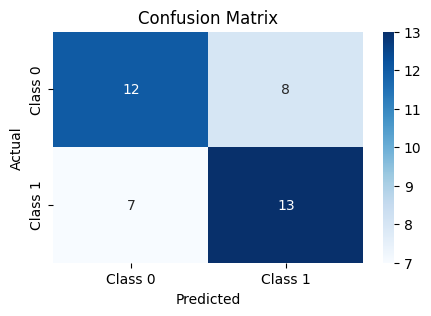

In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the optimized features and labels
train_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/optimized_train_features.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/optimized_test_features.csv")


X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]

X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]


pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

#Perform GridSearchCV
param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 10),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(pipe, param_grid, cv=5)  # 5-fold cross-validation
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Best Parameters: k = {best_params['kneighborsclassifier__n_neighbors']}, weights = {best_params['kneighborsclassifier__weights']}, metric = {best_params['kneighborsclassifier__metric']}")
print("choose KNN best Parameters Done")

# Evaluate on the test set
print("\nEvauate KNN on the Test set...")
y_pred = grid.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#GMM

Best Parameters: n_components: 6, covariance_type: spherical
choose GMM best Parameters Done


Evauate GMM on the Test set...
Accuracy: 77.50%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82        20
         1.0       1.00      0.55      0.71        20

    accuracy                           0.78        40
   macro avg       0.84      0.78      0.76        40
weighted avg       0.84      0.78      0.76        40


Confusion Matrix:


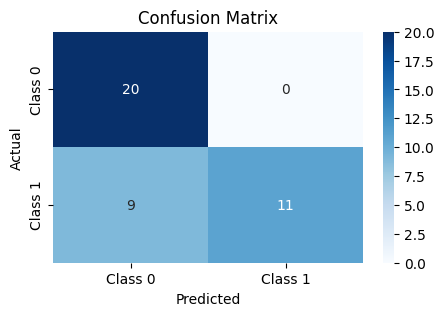

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/optimized_train_features.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Spoken/Project/optimized_test_features.csv")

X_train = train_data.drop(columns=["label"])
y_train = train_data["label"]

X_test = test_data.drop(columns=["label"])
y_test = test_data["label"]

n_components_list = [2, 3, 4, 5,6]
covariance_types = ['full', 'tied', 'diag', 'spherical']

best_accuracy = 0
best_params = {}

# Try all combinations of parameters
for n_components in n_components_list:
    for covariance_type in covariance_types:

        # Train GMMs for each class
        gmm_0 = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        gmm_1 = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)

        # Fit GMMs to each class separately
        gmm_0.fit(X_train[y_train == 0])
        gmm_1.fit(X_train[y_train == 1])

        # Predict using GMM
        def predict_gmm(X_test):
            log_likelihood_0 = gmm_0.score_samples(X_test)  # Log-likelihood for class 0
            log_likelihood_1 = gmm_1.score_samples(X_test)  # Log-likelihood for class 1
            return np.argmax(np.vstack([log_likelihood_0, log_likelihood_1]).T, axis=1)

        y_pred = predict_gmm(X_test)
        accuracy = accuracy_score(y_test, y_pred)


        # Save the best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_components': n_components, 'covariance_type': covariance_type}

# Print the best parameters and accuracy

print(f"Best Parameters: n_components: {best_params['n_components']}, covariance_type: {best_params['covariance_type']}")
print("choose GMM best Parameters Done\n")
print("\nEvauate GMM on the Test set...")
print(f"Accuracy: {best_accuracy * 100:.2f}%")

# Train the best model and evaluate it
gmm_0 = GaussianMixture(n_components=best_params['n_components'], covariance_type=best_params['covariance_type'], random_state=42)
gmm_1 = GaussianMixture(n_components=best_params['n_components'], covariance_type=best_params['covariance_type'], random_state=42)

gmm_0.fit(X_train[y_train == 0])
gmm_1.fit(X_train[y_train == 1])

y_pred = predict_gmm(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
